In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread, imshow
import cv2

%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from collections import defaultdict

import warnings
warnings.filterwarnings("ignore")

from subprocess import check_output
import glob

import PIL
from PIL import Image
#https://www.kaggle.com/philschmidt/cervix-eda-model-selection

In [2]:
#Setting each path to the folders for each type of cervix
basepath = "/Users/keerat/dev/AOSResearch/resources/Train/"
path_type1 = "/Users/keerat/dev/AOSResearch/resources/Train/Type_1"
path_type2 = "/Users/keerat/dev/AOSResearch/resources/Train/Type_2"
path_type3 = "/Users/keerat/dev/AOSResearch/resources/Train/Type_3"
paths = [path_type1, path_type2, path_type3]

#glob will sort through each folder(Type 1, 2, 3) and return the information in it as a list
type1_cervix_images = glob.glob("/Users/keerat/dev/AOSResearch/resources/Train/Type_1/*.jpg")
type2_cervix_images = glob.glob("/Users/keerat/dev/AOSResearch/resources/Train/Type_2/*.jpg")
type3_cervix_images = glob.glob("/Users/keerat/dev/AOSResearch/resources/Train/Type_3/*.jpg")

#all_cervix_images holds all the data
all_cervix_images = type1_cervix_images + type2_cervix_images + type3_cervix_images

#checking the number of each cervix type 
print("The number of Type 1 cervices is {}.".format((len(type1_cervix_images))))
print("The number of Type 2 cervices is {}.".format((len(type2_cervix_images))))
print("The number of Type 3 cervices is {}.".format((len(type3_cervix_images))))
print("The total number of all cervices is {}.".format((len(all_cervix_images))))

#The data has been transported inton a dataframe
all_cervix_images = pd.DataFrame({'imagepath': all_cervix_images})
all_cervix_images['filetype'] = all_cervix_images.apply(lambda row: row.imagepath.split(".")[-1], axis=1)
all_cervix_images['type'] = all_cervix_images.apply(lambda row: row.imagepath.split("/")[-2], axis=1)
all_cervix_images.head()

The number of Type 1 cervices is 236.
The number of Type 2 cervices is 556.
The number of Type 3 cervices is 27.
The total number of all cervices is 819.


,imagepath,filetype,type
0,/Users/keerat/dev/AOSResearch/resources/Train/...,jpg,Type_1
1,/Users/keerat/dev/AOSResearch/resources/Train/...,jpg,Type_1
2,/Users/keerat/dev/AOSResearch/resources/Train/...,jpg,Type_1
3,/Users/keerat/dev/AOSResearch/resources/Train/...,jpg,Type_1
4,/Users/keerat/dev/AOSResearch/resources/Train/...,jpg,Type_1


Text(0.5,0,'training size fraction')

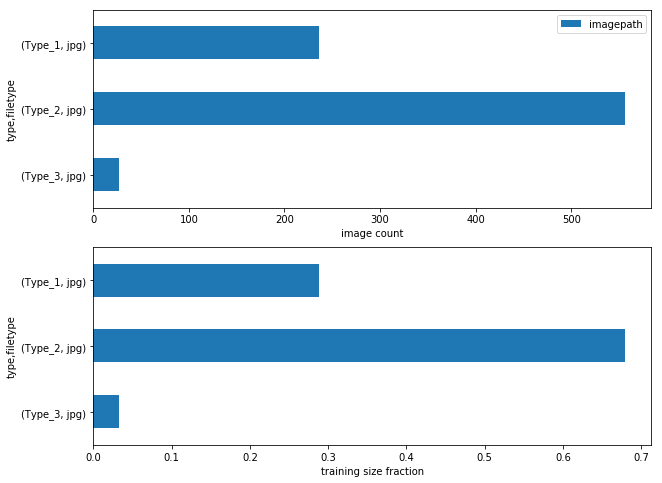

In [3]:
#I can see the relation of the number of images for each type in relation to the entire dataset
type_aggregation = all_cervix_images.groupby(['type', 'filetype']).agg('count')
type_aggregation_p = type_aggregation.apply(lambda row: 1.0*row['imagepath']/all_cervix_images.shape[0], axis=1)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

type_aggregation.plot.barh(ax=axes[0]).invert_yaxis()
axes[0].set_xlabel("image count")
type_aggregation_p.plot.barh(ax=axes[1]).invert_yaxis()
axes[1].set_xlabel("training size fraction")

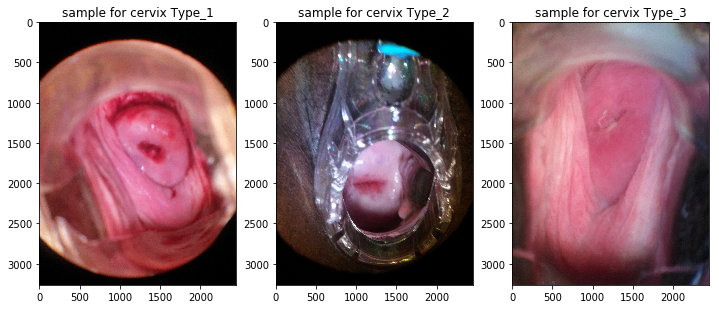

In [4]:
#From this we can get an idea of what images from each type look like
fig = plt.figure(figsize=(12,8))

i = 1
for t in all_cervix_images['type'].unique():
    ax = fig.add_subplot(1,3,i)
    i+=1
    f = all_cervix_images[all_cervix_images['type'] == t]['imagepath'].values[0]
    plt.imshow(plt.imread(f))
    plt.title('sample for cervix {}'.format(t))

In [5]:
#This block of code will return the diferrent image sizes per each class
images = defaultdict(list)

for t in all_cervix_images['type'].unique():
    sample_counter = 0
    for _, row in all_cervix_images[all_cervix_images['type'] == t].iterrows():
        #print('reading image {}'.format(row.imagepath))
        try:
            img = imread(row.imagepath)
            sample_counter +=1
            images[t].append(img)
        except:
            print('image read failed for {}'.format(row.imagepath))

dfs = []
for t in all_cervix_images['type'].unique():
    t_ = pd.DataFrame(
        {
            'nrows': list(map(lambda i: i.shape[0], images[t])),
            'ncols': list(map(lambda i: i.shape[1], images[t])),
            'nchans': list(map(lambda i: i.shape[2], images[t])),
            'type': t
        }
    )
    dfs.append(t_)

shapes_df = pd.concat(dfs, axis=0)
shapes_df_grouped = shapes_df.groupby(by=['nchans', 'ncols', 'nrows', 'type']).size().reset_index().sort_values(['type', 0], ascending=False)
shapes_df_grouped

image read failed for /Users/keerat/dev/AOSResearch/resources/Train/Type_1/1339.jpg


,nchans,ncols,nrows,type,0
7,3,2448,3264,Type_3,20
10,3,3096,4128,Type_3,3
15,3,3264,2448,Type_3,3
2,3,480,640,Type_3,1
6,3,2448,3264,Type_2,320
9,3,3096,4128,Type_2,198
14,3,3264,2448,Type_2,13
4,3,2322,4128,Type_2,9
12,3,3120,4160,Type_2,7
18,3,4128,3096,Type_2,5


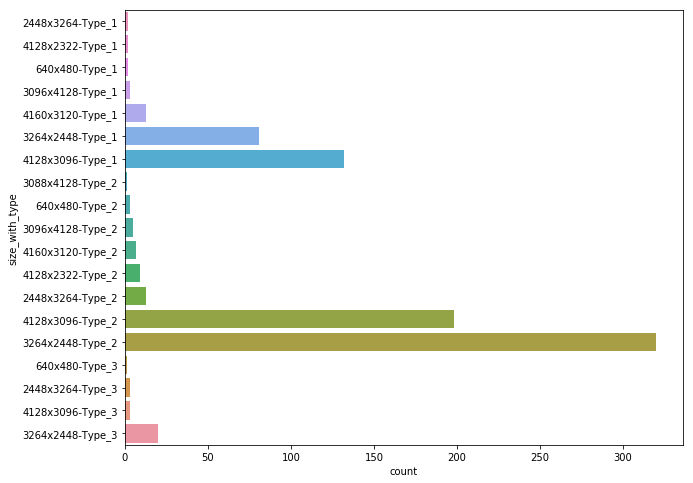

In [6]:
#I need to visualize the above table, so I can do this using a barplot
shapes_df_grouped['size_with_type'] = shapes_df_grouped.apply(lambda row: '{}x{}-{}'.format(row.nrows, row.ncols, row.type), axis=1)
shapes_df_grouped = shapes_df_grouped.set_index(shapes_df_grouped['size_with_type'].values)
shapes_df_grouped['count'] = shapes_df_grouped[[0]]

plt.figure(figsize=(10,8))
sns.barplot(x="count", y="size_with_type", data=shapes_df_grouped).invert_yaxis()

In [7]:
#Method for histogram equalizations as found on
#https://www.researchgate.net/publication/281118372_NumPy_SciPy_Recipes_for_Image_Processing_Intensity_Normalization_and_Histogram_Equalization
#Takes in the image and returns a more uniform distribution of pixel values, thus increasing contrast
def equalize(f):
    h = np.histogram(f, bins=np.arange(257))[0]
    H = np.cumsum(h) / float(np.sum(h))
    e = np.floor(H[f.flatten().astype("int")]*256.)
    return e.reshape(f.shape)

In [35]:
#Here, I am using my equalize method to change each image in the all_cervix_image data structure using histogram equalizations.
for t in all_cervix_images['imagepath'].unique():
    f = all_cervix_images['imagepath' == t].values[0]
    all_cervix_images['imagepath' == t].vales[0] = equalize(plt.imread(f))
# I am basing this method off the one I used when sampling one image, an error is occuring that I will need to address    
#for t in all_cervix_images['type'].unique():
 #   f = all_cervix_images[all_cervix_images['type'] == t]['imagepath'].values[0]
  #  print(t)
   # f = equalize(plt.imread(f))
    #plt.imshow(f)

KeyError: False

In [17]:
#Trying principal componenent analysis http://sebastianraschka.com/Articles/2014_pca_step_by_step.html#drop_labels

def transform_image(img, rescaled_dim): #This method is to resize the images to a standard size before doing PCA
    resized = cv2.resize(img, (rescaled_dim, rescaled_dim), cv2.INTER_LINEAR)
    
    normalized = cv2.normalize(resized.astype(float), None, 0.0, 1.0, cv2.NORM_MINMAX)
    timg = normalized.reshape(1, np.prod(normalized.shape))

    return timg/np.linalg.norm(timg)

rescaled_dim = 100

all_images = []
all_image_types = []

for t in all_cervix_images['type'].unique():
    all_images += images[t]
    all_image_types += len(images[t])*[t]

# - normalize each image to the value interval [0, 1] as float image
# - resize image to rescaled_dim X rescaled_dim
# - L2 norm of each sample = 1
gray_all_images_as_vecs = [transform_image(img, rescaled_dim) for img in all_images]

gray_imgs_mat = np.array(gray_all_images_as_vecs).squeeze()
all_image_types = np.array(all_image_types)
gray_imgs_mat.shape, all_image_types.shape #This is not working, I am talking to Dr. Oguz about this fix.

array([[[116,  94, 132],
        [115,  93, 131],
        [119,  97, 135],
        ..., 
        [154, 141, 185],
        [153, 140, 184],
        [151, 138, 182]],

       [[114,  92, 130],
        [113,  91, 129],
        [117,  95, 133],
        ..., 
        [153, 140, 184],
        [156, 141, 184],
        [156, 141, 184]],

       [[115,  93, 131],
        [114,  92, 130],
        [117,  95, 133],
        ..., 
        [154, 139, 182],
        [155, 140, 183],
        [155, 140, 183]],

       ..., 
       [[138, 128, 155],
        [140, 130, 157],
        [140, 130, 157],
        ..., 
        [127, 140, 156],
        [129, 145, 160],
        [127, 143, 158]],

       [[137, 127, 154],
        [139, 129, 156],
        [138, 128, 155],
        ..., 
        [124, 140, 155],
        [129, 145, 160],
        [126, 142, 157]],

       [[136, 126, 153],
        [139, 129, 156],
        [138, 128, 155],
        ..., 
        [122, 138, 153],
        [128, 144, 159],
        [126, 142,

In [29]:
#These are the three methods I have found to be used for PCA, as of now I need to edit them to work for my images
#Test methods that I will later look into
def maxHist(hist):
    maxArea = (0, 0, 0)
    height = []
    position = []
    for i in range(len(hist)):
        if (len(height) == 0):
            if (hist[i] > 0):
                height.append(hist[i])
                position.append(i)
        else: 
            if (hist[i] > height[-1]):
                height.append(hist[i])
                position.append(i)
            elif (hist[i] < height[-1]):
                while (height[-1] > hist[i]):
                    maxHeight = height.pop()
                    area = maxHeight * (i-position[-1])
                    if (area > maxArea[0]):
                        maxArea = (area, position[-1], i)
                    last_position = position.pop()
                    if (len(height) == 0):
                        break
                position.append(last_position)
                if (len(height) == 0):
                    height.append(hist[i])
                elif(height[-1] < hist[i]):
                    height.append(hist[i])
                else:
                    position.pop()    
    while (len(height) > 0):
        maxHeight = height.pop()
        last_position = position.pop()
        area =  maxHeight * (len(hist) - last_position)
        if (area > maxArea[0]):
            maxArea = (area, len(hist), last_position)
    return maxArea
            

def maxRect(img):
    maxArea = (0, 0, 0)
    addMat = np.zeros(img.shape)
    for r in range(img.shape[0]):
        if r == 0:
            addMat[r] = img[r]
            area = maxHist(addMat[r])
            if area[0] > maxArea[0]:
                maxArea = area + (r,)
        else:
            addMat[r] = img[r] + addMat[r-1]
            addMat[r][img[r] == 0] *= 0
            area = maxHist(addMat[r])
            if area[0] > maxArea[0]:
                maxArea = area + (r,)
    return (int(maxArea[3]+1-maxArea[0]/abs(maxArea[1]-maxArea[2])), maxArea[2], maxArea[3], maxArea[1], maxArea[0])

def cropCircle(img):
    if(img.shape[0] > img.shape[1]):
        tile_size = (int(img.shape[1]*256/img.shape[0]),256)
    else:
        tile_size = (256, int(img.shape[0]*256/img.shape[1]))

    img = cv2.resize(img, dsize=tile_size)
            
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY);
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

    _, contours, _ = cv2.findContours(thresh.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)

    main_contour = sorted(contours, key = cv2.contourArea, reverse = True)[0]
            
    ff = np.zeros((gray.shape[0],gray.shape[1]), 'uint8') 
    cv2.drawContours(ff, main_contour, -1, 1, 15)
    ff_mask = np.zeros((gray.shape[0]+2,gray.shape[1]+2), 'uint8')
    cv2.floodFill(ff, ff_mask, (int(gray.shape[1]/2), int(gray.shape[0]/2)), 1)
    
    rect = maxRect(ff)
    rectangle = [min(rect[0],rect[2]), max(rect[0],rect[2]), min(rect[1],rect[3]), max(rect[1],rect[3])]
    img_crop = img[rectangle[0]:rectangle[1], rectangle[2]:rectangle[3]]
    cv2.rectangle(ff,(min(rect[1],rect[3]),min(rect[0],rect[2])),(max(rect[1],rect[3]),max(rect[0],rect[2])),3,2)
    
    return [img_crop, rectangle, tile_size]